# Предсказание start_cluster для 6 месяца с помощью CatBoost

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [6]:
train_data = pd.read_parquet('/kaggle/input/train-test-data/train_data.pqt')
test_data = pd.read_parquet('/kaggle/input/train-test-data/test_data.pqt')

***Добавим для каждого объекта кластер предыдущего месяца, если для объекта нет данных о предыдущем месяце, prev_cluster = 'None'***

***Добавление previos cluster для предсказания start_cluster_6***

In [7]:
prev_cluster = train_data['start_cluster'].shift()
prev_cluster.iloc[0::3] = 'None'
prev_cluster_test = test_data['start_cluster'].shift()
train_data['prev_cluster'] = prev_cluster
test_data['prev_cluster'] = prev_cluster_test.astype('str')

***Добавление вероятностей перехода из prev_cluster во все кластеры кластеры***

In [8]:
m1 = pd.Series(train_data['start_cluster'][train_data['date'] == 'month_1'].to_numpy())
m2 = pd.Series(train_data['start_cluster'][train_data['date'] == 'month_2'].to_numpy())
m3 = pd.Series(train_data['start_cluster'][train_data['date'] == 'month_3'].to_numpy())
m4 = test_data['start_cluster'][test_data['date'] == 'month_4']
index = np.array(m4.index + 1)
m5 = test_data['start_cluster'][index]
m4 = pd.Series(np.array(m4))
m5 = pd.Series(np.array(m5))

In [9]:
#создадим массив со всеми кластерами
clusters = train_data['start_cluster'].unique()

In [10]:
#создание таблицы вероятностей перехода из prev_cluster в каждый кластер 
d1 = dict()
for i in clusters:
    d1[i] = []
    for j in clusters:
        d1[i].append(
            (len(m4[(m4 == i) & (m5 == j)]) + 
             len(m1[(m1 == i) & (m2 == j)]) + 
             len(m2[(m2 == i) & (m3 == j)]))/ 
            (len(m4[(m4 == i)]) + len(m1[(m1 == i)]) + len(m2[(m2 == i)]))
        )
d1['None'] = []
for j in clusters:
    d1['None'].append((len(m4[m4 == j]) + len(m1[m1 == j]))/(len(m4) + len(m1)))
d1 = pd.DataFrame(d1, index = clusters ).T
d1

,"{α, γ}",{other},{α},{},"{α, ε, ψ}","{α, δ}","{α, η}","{α, β}","{α, ε, η}","{α, μ}","{α, ψ}","{α, λ}","{α, ε}","{α, ε, θ}","{α, θ}",{λ},"{α, π}"
"{α, γ}",0.926026,0.035783,0.036686,0.000941,0.000000,0.000075,0.000113,0.000113,0.000000,0.000000,0.000038,0.000000,0.000113,0.000000,0.000113,0.000000,0.000000
{other},0.031401,0.925519,0.004099,0.001121,0.000657,0.003828,0.009165,0.005607,0.000735,0.001470,0.005375,0.000735,0.004525,0.001083,0.004679,0.000000,0.000000
{α},0.005252,0.001127,0.957642,0.019070,0.000007,0.002764,0.007706,0.003661,0.000010,0.000494,0.000293,0.000213,0.001154,0.000007,0.000594,0.000000,0.000007
{},0.005213,0.005226,0.328802,0.634133,0.000000,0.000727,0.019740,0.001468,0.000055,0.001221,0.000165,0.000027,0.000713,0.000000,0.002414,0.000096,0.000000
"{α, ε, ψ}",0.000000,0.041667,0.003472,0.003472,0.892361,0.000000,0.000000,0.000000,0.000000,0.000000,0.034722,0.000000,0.024306,0.000000,0.000000,0.000000,0.000000
"{α, δ}",0.000565,0.026145,0.110514,0.001413,0.000000,0.860656,0.000000,0.000565,0.000000,0.000000,0.000000,0.000000,0.000141,0.000000,0.000000,0.000000,0.000000
"{α, η}",0.000086,0.016510,0.035996,0.002032,0.000000,0.000029,0.942600,0.000029,0.002547,0.000114,0.000000,0.000000,0.000000,0.000000,0.000057,0.000000,0.000000
"{α, β}",0.000858,0.029895,0.076574,0.000613,0.000000,0.000368,0.000245,0.891081,0.000000,0.000123,0.000123,0.000000,0.000000,0.000000,0.000123,0.000000,0.000000
"{α, ε, η}",0.000000,0.022634,0.000000,0.000000,0.000000,0.000000,0.017490,0.000000,0.934156,0.000000,0.000000,0.000000,0.025720,0.000000,0.000000,0.000000,0.000000
"{α, μ}",0.000917,0.047706,0.073394,0.000000,0.000000,0.000000,0.003670,0.000000,0.000000,0.874312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
#соеденим train и test данные  для последующего join с вероятностями перехода в каждый кластер
train_data.drop(['end_cluster'], axis = 1, inplace = True)
X = pd.concat([train_data, test_data])
X.index = np.arange(0, len(X))
X

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,prev_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",None
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}","{α, γ}"
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}","{α, γ}"
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,None,...,0.945281,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},None
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,None,...,0.946066,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890115,299998,month_5,NaN,NaN,NaN,NaN,None,None,None,None,...,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{},None
890116,299998,month_6,-0.155350,-0.203711,-0.125995,-0.155980,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,None,{}
890117,299999,month_4,-0.145899,-0.173298,-0.125995,-0.145402,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.944497,0.384773,-0.097640,0.550901,0.574354,-0.101369,0.252657,0.440474,{α},None
890118,299999,month_5,-0.136402,-0.163874,-0.121475,-0.135876,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.944497,0.384773,-0.047885,0.555057,0.696576,-0.034860,0.253523,0.473441,{α},{α}


In [12]:
#соединение двух таблиц
start_cluster = X['start_cluster']
X.drop(['start_cluster'], axis = 1, inplace = True)
cat_cols = np.array(X.select_dtypes(exclude = 'float64').columns)
X[cat_cols] = X[cat_cols].astype('str')
X_copy = X.copy()
features1 = d1.copy()
joined_X = X_copy.set_index('prev_cluster').join(features1)
joined_X['prev_cluster'] = joined_X.index
joined_X['id'] = joined_X['id'].astype('int')
joined_X = joined_X.sort_values(['id', 'date'])
joined_X.index = np.arange(0, len(X))
joined_X.drop(['id', 'date'], axis = 1, inplace = True)

In [13]:
cat_cols = np.array(joined_X.select_dtypes(exclude = 'float64').columns)

***Обучение модели***

In [14]:
#Делим выборку на обучающую и валидационную
X_train, X_val, y_train, y_val = train_test_split(joined_X[X['date'] != 'month_6'], start_cluster[X['date'] != 'month_6'], stratify = start_cluster[X['date'] != 'month_6'], random_state = 1)

In [15]:
#в дальнейшем будет использоваться в optuna
cluster_weights = pd.read_excel(
    "/kaggle/input/cluster-weights/cluster_weights.xlsx"
).set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [16]:
#Обучим модель на всех данных для выявления важности каждого признака
model = CatBoostClassifier(n_estimators = 1000, task_type = 'GPU', verbose = 1000, learning_rate = 0.1)
model.fit(joined_X[X['date'] != 'month_6'], start_cluster[X['date'] != 'month_6'], cat_features = cat_cols)

0:	learn: 1.8096055	total: 7.46s	remaining: 2h 4m 17s
999:	learn: 0.3234989	total: 1m 19s	remaining: 0us


In [17]:
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                        из отображаемых горячие фичи, и изучить менее сильные
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,15))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    print(list(fi_df['feature_names'][:top_n]))
    return fi_df

['{α}', '{λ}', 'okved', 'cnt_a_oper_3m', '{}', 'balance_amt_max', 'segment', 'sum_of_paym_1y', '{α, η}', 'cnt_cred_e_oper_3m', 'balance_amt_min', '{α, γ}', 'sum_cred_e_oper_3m', 'channel_code', 'prev_cluster', 'city', 'sum_deb_e_oper_3m', '{α, λ}', 'index_city_code', '{α, δ}', 'cnt_days_cred_e_oper_3m', 'cnt_deb_e_oper_3m', 'sum_cred_h_oper_3m', 'max_founderpres', 'ogrn_exist_months', 'min_founderpres', 'sum_of_paym_6m', 'ogrn_year', 'ft_registration_date', 'ogrn_month', 'balance_amt_day_avg', '{other}', 'cnt_deb_e_oper_1m', 'cnt_days_cred_e_oper_1m', '{α, θ}', 'sum_b_oper_3m', '{α, β}', '{α, π}', 'sum_deb_h_oper_3m', 'cnt_days_deb_e_oper_3m', '{α, ε}', 'cnt_cred_h_oper_3m', 'sum_deb_e_oper_1m', 'ogrn_days_end_quarter', 'balance_amt_avg', 'sum_of_paym_2m', 'cnt_b_oper_3m', 'ogrn_days_end_month', 'sum_deb_h_oper_1m', 'sum_cred_e_oper_1m', 'cnt_cred_e_oper_1m', '{α, ε, θ}', 'cnt_days_deb_f_oper_3m', 'sum_deb_d_oper_3m', '{α, μ}', 'sum_deb_f_oper_3m', 'sum_deb_f_oper_1m', 'cnt_days_deb_g_

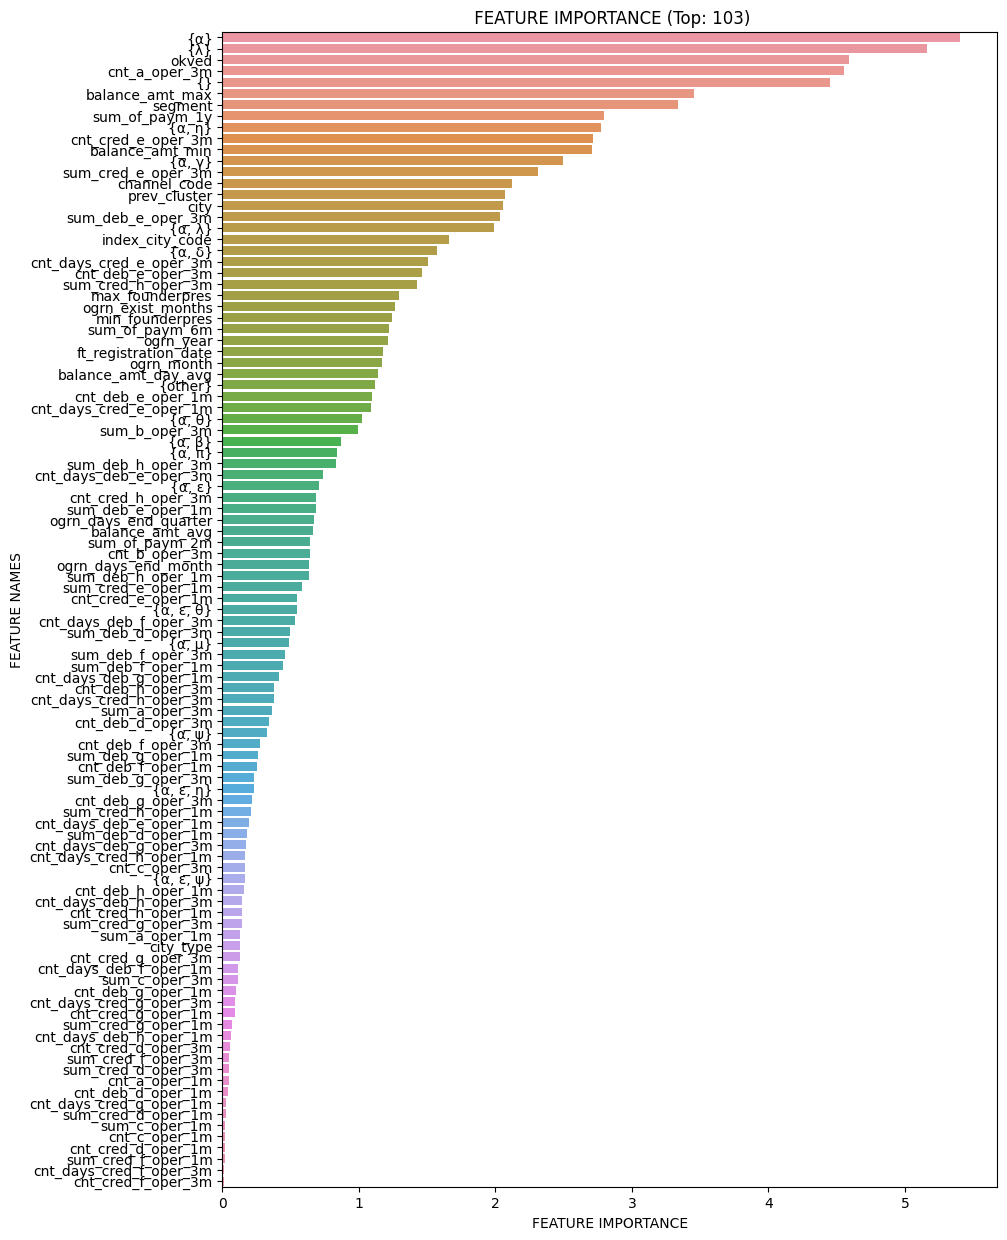

In [18]:
df_ = plot_feature_importance(model.get_feature_importance(), X_val.columns, top_n = 103)

In [20]:
#список признаков отсортированных по важности
sorted_features = ['{α}', 'okved', '{λ}', '{}', 'cnt_a_oper_3m', 'balance_amt_max', 'segment', 'balance_amt_min', 'cnt_cred_e_oper_3m', '{α, η}', 'sum_of_paym_1y', '{α, γ}', 'sum_cred_e_oper_3m', 'channel_code', 'city', 'prev_cluster', '{α, λ}', 'sum_deb_e_oper_3m', 'index_city_code', '{α, δ}', 'cnt_days_cred_e_oper_3m', 'ogrn_exist_months', 'cnt_deb_e_oper_3m', 'sum_cred_h_oper_3m', 'min_founderpres', 'ogrn_month', 'max_founderpres', 'ogrn_days_end_quarter', 'ogrn_year', 'balance_amt_day_avg', 'ft_registration_date', 'sum_of_paym_6m', 'cnt_days_cred_e_oper_1m', 'cnt_deb_e_oper_1m', '{other}', '{α, θ}', '{α, β}', 'sum_b_oper_3m', '{α, π}', 'sum_of_paym_2m', 'cnt_days_deb_e_oper_3m', 'ogrn_days_end_month', 'sum_deb_h_oper_3m', 'sum_deb_e_oper_1m', '{α, ε}', 'balance_amt_avg', 'sum_cred_e_oper_1m', 'sum_deb_h_oper_1m', '{α, ε, θ}', 'cnt_cred_h_oper_3m', 'cnt_cred_e_oper_1m', 'cnt_days_deb_f_oper_3m', 'sum_deb_d_oper_3m', '{α, μ}', 'sum_deb_f_oper_3m', 'cnt_deb_d_oper_3m', 'cnt_b_oper_3m', 'sum_deb_f_oper_1m', '{α, ε, η}', 'cnt_deb_h_oper_3m', 'cnt_days_cred_h_oper_3m', 'sum_a_oper_3m', 'cnt_days_deb_g_oper_1m', 'sum_deb_g_oper_3m', 'cnt_deb_f_oper_3m', '{α, ψ}', 'sum_deb_g_oper_1m', 'sum_cred_h_oper_1m', 'cnt_deb_f_oper_1m', 'cnt_c_oper_3m', 'cnt_deb_g_oper_3m', 'cnt_days_deb_e_oper_1m', '{α, ε, ψ}', 'city_type', 'sum_deb_d_oper_1m', 'cnt_days_deb_g_oper_3m', 'cnt_deb_h_oper_1m', 'cnt_cred_h_oper_1m', 'cnt_cred_g_oper_3m', 'sum_a_oper_1m', 'cnt_days_deb_h_oper_3m', 'sum_c_oper_3m', 'cnt_days_cred_h_oper_1m', 'cnt_deb_g_oper_1m', 'sum_cred_g_oper_3m', 'cnt_days_deb_f_oper_1m', 'cnt_cred_d_oper_3m', 'cnt_a_oper_1m', 'cnt_cred_g_oper_1m', 'sum_cred_g_oper_1m', 'cnt_days_deb_h_oper_1m', 'sum_cred_f_oper_3m', 'sum_cred_d_oper_3m', 'cnt_deb_d_oper_1m', 'sum_cred_d_oper_1m', 'sum_c_oper_1m', 'cnt_days_cred_g_oper_1m', 'cnt_cred_d_oper_1m', 'sum_cred_f_oper_1m', 'cnt_c_oper_1m', 'cnt_days_cred_g_oper_3m', 'cnt_cred_f_oper_3m', 'cnt_days_cred_f_oper_3m']

In [18]:
#выявление лучшего количества фичей
results = []
for i in range(35, 76, 5):
    cols = sorted_features[:i]
    new_X_train = X_train[cols]
    new_X_val = X_val[cols]
    cat_cols = np.array(new_X_train.select_dtypes(exclude = 'float64').columns)
    model = CatBoostClassifier(n_estimators = 1000, task_type = 'GPU', verbose = 1000)
    model.fit(new_X_train, y_train, cat_features = cat_cols, eval_set = (new_X_val, y_val))
    y_pred = model.predict(new_X_val)
    results.append([f1_score(y_val, y_pred, average = 'weighted'), i]) # выбрана метрика f1(weighted) в силу сильного дисбаланса классов
    print(results[-1])

Learning rate set to 0.200392
0:	learn: 1.1285950	test: 1.1269611	best: 1.1269611 (0)	total: 51.9ms	remaining: 51.8s
999:	learn: 0.3059421	test: 0.3602286	best: 0.3601481 (964)	total: 48.5s	remaining: 0us
bestTest = 0.360148063
bestIteration = 964
Shrink model to first 965 iterations.
[0.8817203512589741, 35]
Learning rate set to 0.200392
0:	learn: 1.1285958	test: 1.1269614	best: 1.1269614 (0)	total: 51.2ms	remaining: 51.2s
999:	learn: 0.3059023	test: 0.3589344	best: 0.3589321 (991)	total: 48.4s	remaining: 0us
bestTest = 0.3589320689
bestIteration = 991
Shrink model to first 992 iterations.
[0.8819092821569536, 40]
Learning rate set to 0.200392
0:	learn: 1.1140101	test: 1.1125617	best: 1.1125617 (0)	total: 53.5ms	remaining: 53.5s
999:	learn: 0.3036693	test: 0.3576094	best: 0.3575880 (957)	total: 49.5s	remaining: 0us
bestTest = 0.3575879692
bestIteration = 957
Shrink model to first 958 iterations.
[0.8821497633454862, 45]
Learning rate set to 0.200392
0:	learn: 1.1140104	test: 1.1125614

In [19]:
#видим что метрика перестает значительно расти после топ-65 признаков, если взять большее количество фичей есть риск переобучиться
results.sort()
results

[[0.8817203512589741, 35],
 [0.8819092821569536, 40],
 [0.8821497633454862, 45],
 [0.8822815440384152, 50],
 [0.8841012496205011, 55],
 [0.8862123197400495, 60],
 [0.8862256123896403, 70],
 [0.8866433874124022, 65],
 [0.8871694306225528, 75]]

In [21]:
cols = sorted_features[:65]
new_X_train = X_train[cols]
new_X_val = X_val[cols]
cat_cols = np.array(new_X_train.select_dtypes(exclude = 'float64').columns)

***OPTUNA***

попробуем подобрать лучшие гиперпараметры для модели с помощью optuna

In [196]:
def objective(trial):
    params_cat = {
        "loss_function": "MultiClass",
        "n_estimators": trial.suggest_int('n_estimators', 900, 1100),
        "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.1, step = 0.01),
        "depth": trial.suggest_int('depth', 4, 7),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 4, 8, step = 0.1),
        "random_state": 42,
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 3, 8),
        "task_type": 'GPU',
        "early_stopping_rounds": 17, 
        "class_weights": weights_dict,
        "verbose": 1000
    }
    model = CatBoostClassifier(**params_cat)
    model.fit(new_X_train, y_train, cat_features = cat_cols, eval_set=[(new_X_val, y_val)])

    y_pred = model.predict(new_X_val)
    score = f1_score(y_val, y_pred, average = 'weighted') # выбрана метрика f1(weighted) в силу сильного дисбаланса классов
    return score

In [199]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

In [22]:
#Лучшие гиперпараметры подобранные OPTUNA
params = {
    "loss_function": "MultiClass",
    "random_state": 42,
    "task_type": "GPU",
    'n_estimators': 1080,
    'learning_rate': 0.09897112383786441,
    'depth': 7,
    'l2_leaf_reg': 5.2,
    'min_data_in_leaf': 5,
    "verbose": 1000,
    "early_stopping_rounds":  17,
    "class_weights": weights_dict,
}


In [56]:
#Обучим модель на всех данных с лучшими гиперпараметрами
cols = sorted_features[:65]
new_joined_X = joined_X[cols]
cat_cols = np.array(new_joined_X.select_dtypes(exclude = 'float64').columns)
model = CatBoostClassifier(**params)
model.fit(new_joined_X[X['date'] != 'month_6'], start_cluster[X['date'] != 'month_6'], cat_features = cat_cols)
start_6 = model.predict(new_joined_X[X['date'] == 'month_6'])
pd.DataFrame(start_6).to_csv('start_cluster_6_predict.csv') #predict start_cluster для 6 месяца

0:	learn: 1.7968826	total: 99.6ms	remaining: 1m 47s
1000:	learn: 0.3213130	total: 1m 36s	remaining: 7.6s
1079:	learn: 0.3177042	total: 1m 43s	remaining: 0us
